In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantumwalks.discrete_walk import QuantumWalk


Evolution: 100%|██████████| 100/100 [00:00<00:00, 525.67it/s]


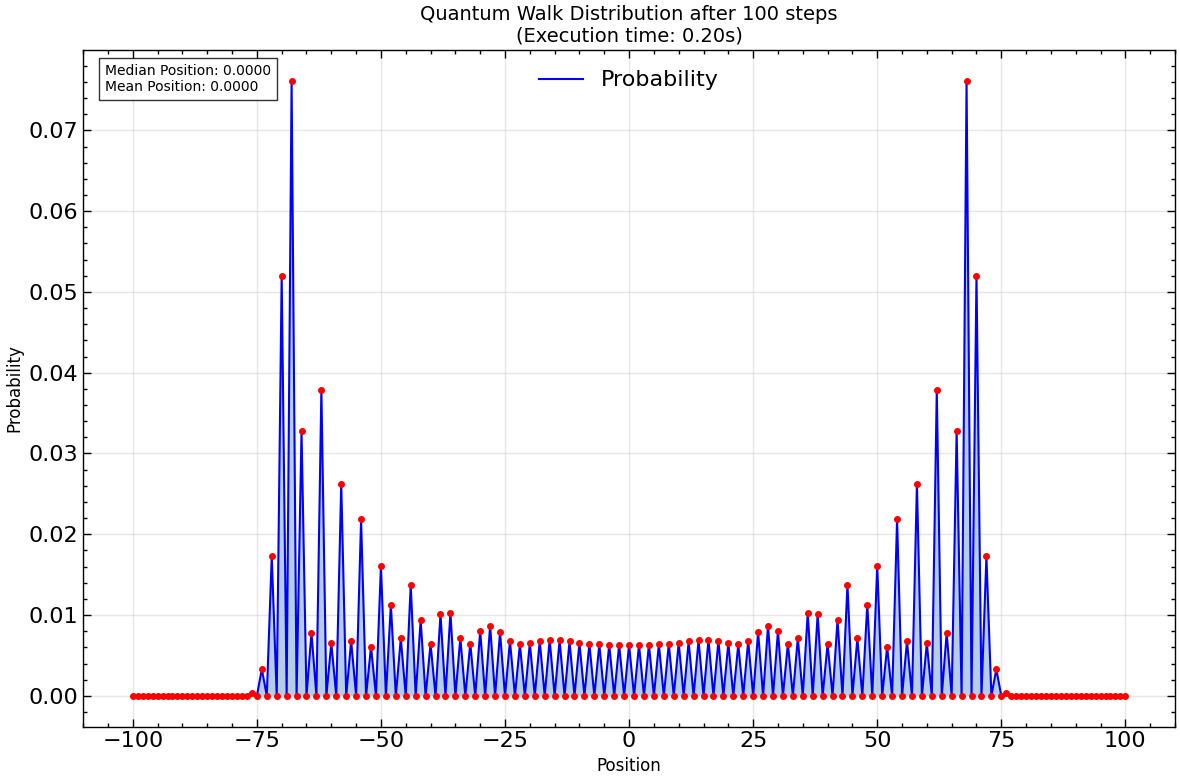

In [2]:
qw = QuantumWalk(num_steps=100)
prob, exec_time, prob_history = qw.simulate()  # Unpack all three returned values
qw.plot_results(prob, exec_time)

Evolution: 100%|██████████| 100/100 [00:00<00:00, 476.41it/s]


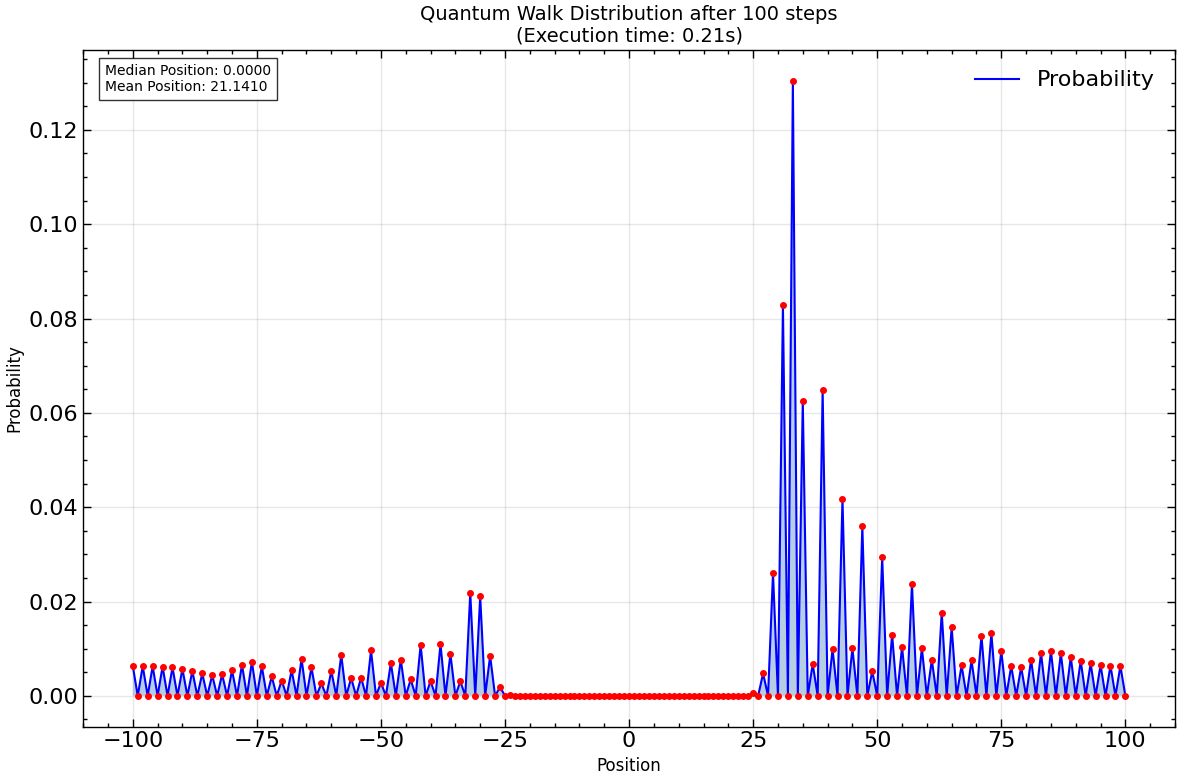

In [3]:
qw = QuantumWalk(
    num_steps=100,
    initial_position=0,  # Start at position 0
    initial_coin_state=np.array([0, 1]),
)

# Run simulation with state storage
prob, exec_time, states, prob_history = qw.simulate(store_states=True)  # Now unpacks 4 values when store_states=True

# Analyze results
stats = qw.analyze_statistics(prob)
qw.plot_results(prob, exec_time)

In [4]:
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict
import numpy as np
from quantumwalks.discrete_walk import QuantumWalk
from quantumwalks.utils.operators import create_parametric_coin, CoinSchedule

def calculate_lr_difference(prob: np.ndarray, max_steps: int) -> float:
    """Calculate P_L - P_R from probability distribution"""
    # Create positions array for the full range
    positions = np.arange(-max_steps, max_steps + 1)
    assert len(positions) == len(prob), f"Position array size {len(positions)} doesn't match probability array size {len(prob)}"

    P_L = np.sum(prob[positions < 0])
    P_R = np.sum(prob[positions > 0])
    return P_L - P_R

def compare_coin_configurations_over_time(
    max_steps: int,
    coin_A_params: Tuple[float, float, float],
    coin_B_params: Tuple[float, float, float],
    initial_state: Optional[np.ndarray] = None
) -> Dict[str, np.ndarray]:
    """Compare P_L - P_R evolution for different coin configurations"""

    # Create coin operators
    alpha_A, beta_A, gamma_A = coin_A_params
    alpha_B, beta_B, gamma_B = coin_B_params

    coin_A = create_parametric_coin(alpha_A, beta_A, gamma_A)
    coin_B = create_parametric_coin(alpha_B, beta_B, gamma_B)

    differences = {
        'A': np.zeros(max_steps),
        'B': np.zeros(max_steps),
        'ABAB': np.zeros(max_steps)
    }

    # Simulate each configuration once
    # Coin A
    fixed_schedule_A = CoinSchedule("fixed", coins={"default": coin_A.toarray()})
    qw_A = QuantumWalk(num_steps=max_steps, coin_schedule=fixed_schedule_A, initial_coin_state=initial_state)
    _, _, prob_history_A = qw_A.simulate()

    # Coin B
    fixed_schedule_B = CoinSchedule("fixed", coins={"default": coin_B.toarray()})
    qw_B = QuantumWalk(num_steps=max_steps, coin_schedule=fixed_schedule_B, initial_coin_state=initial_state)
    _, _, prob_history_B = qw_B.simulate()

    # Alternating coins
    alternating_schedule = CoinSchedule("alternating", coins={"A": coin_A.toarray(), "B": coin_B.toarray()})
    qw_AB = QuantumWalk(num_steps=max_steps, coin_schedule=alternating_schedule, initial_coin_state=initial_state)
    _, _, prob_history_AB = qw_AB.simulate()

    # Calculate P_L - P_R for each step
    for step in range(max_steps):
        differences['A'][step] = calculate_lr_difference(prob_history_A[step+1], max_steps)
        differences['B'][step] = calculate_lr_difference(prob_history_B[step+1], max_steps)
        differences['ABAB'][step] = calculate_lr_difference(prob_history_AB[step+1], max_steps)

    return differences

def plot_lr_differences(
    differences: Dict[str, np.ndarray],
    coin_params: Dict[str, Tuple[float, float, float]],
    max_steps: int
):
    """Plot P_L - P_R evolution for different configurations"""
    plt.figure(figsize=(12, 8))
    steps = np.arange(1, max_steps + 1)

    # Convert angles to degrees for display
    def to_degrees(angles):
        return tuple(np.degrees(angle) for angle in angles)

    plt.plot(steps, differences['A'], 'r.',
             label=f'Coin A (α={to_degrees(coin_params["A"])[0]:.1f}°, β={to_degrees(coin_params["A"])[1]:.1f}°, γ={to_degrees(coin_params["A"])[2]:.1f}°)',
             alpha=0.7)
    plt.plot(steps, differences['B'], 'g.',
             label=f'Coin B (α={to_degrees(coin_params["B"])[0]:.1f}°, β={to_degrees(coin_params["B"])[1]:.1f}°, γ={to_degrees(coin_params["B"])[2]:.1f}°)',
             alpha=0.7)
    plt.plot(steps, differences['ABAB'], 'b.',
             label='Alternating A-B',
             alpha=0.7)
    plt.ylim([-1, 1])
    plt.grid(True, alpha=0.3)
    plt.xlabel('Number of Steps', fontsize=12)
    plt.ylabel('P_L - P_R', fontsize=12)
    plt.title('Evolution of Left-Right Probability Difference', fontsize=14)
    plt.legend()

    # Add median values
    median_text = []
    for config in ['A', 'B', 'ABAB']:
        median_diff = np.median(differences[config])
        median_text.append(f"{config}: Median={median_diff:.4f}")

    plt.text(0.02, 0.98, '\n'.join(median_text),
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()


Evolution: 100%|██████████| 1000/1000 [00:08<00:00, 112.73it/s]


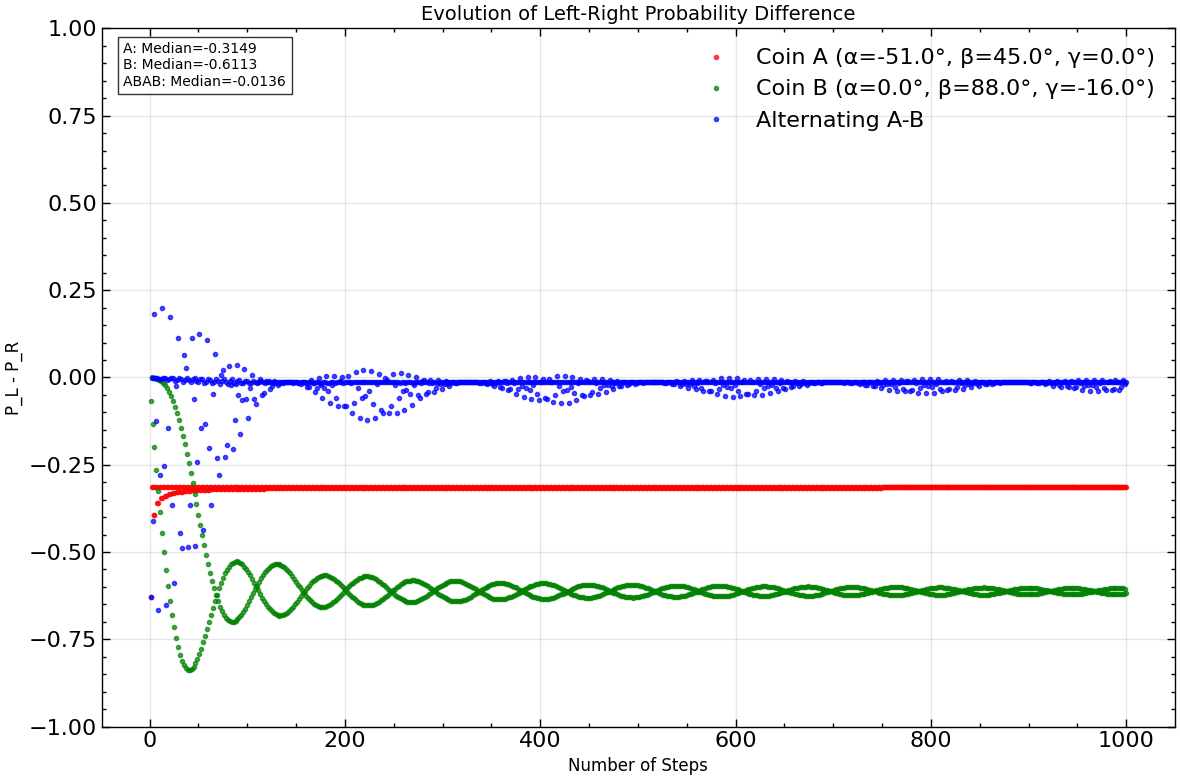

In [5]:

if __name__ == "__main__":
    # Set parameters
    max_steps = 1000  # Reduced number of steps for faster computation

    # Parameters for Coin A (in radians)
    coin_A_params = (-51.0/180 * np.pi,  # alpha
                     45.0/180 * np.pi,   # beta
                      0.0/180 * np.pi)   # gamma

    # Parameters for Coin B (in radians)
    coin_B_params = (0.0/180 * np.pi,    # alpha
                    88.0/180 * np.pi,    # beta
                   -16.0/180 * np.pi)    # gamma

    # Initial coin state
    initial_state = np.array([1, -1], dtype=np.complex128) / np.sqrt(2)

    # Calculate P_L - P_R evolution
    differences = compare_coin_configurations_over_time(
        max_steps=max_steps,
        coin_A_params=coin_A_params,
        coin_B_params=coin_B_params,
        initial_state=initial_state
    )

    # Plot results
    coin_params = {
        "A": coin_A_params,
        "B": coin_B_params
    }

    plot_lr_differences(differences, coin_params, max_steps)
